In [ ]:
import numpy as np
import gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Initialize the environment
env = gym.make("Pendulum-v1", render_mode="rgb_array")

# Number of features at each state
num_states = env.observation_space.shape[0]

# Lower and upper bound of the action space
upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

# Discretize the continuous action space
num_actions = 41
discritized_actions = np.linspace(env.action_space.low[0], env.action_space.high[0], num_actions)

In [3]:
# Transition as a namedtuple: a simple data structure to group together s_t, a_t, r, s_t+1
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state'))

# Cyclic buffer: holds the recent transitions + sampling a random batch of transitions for training
class ReplayBuffer(object):

    def __init__(self, capacity=128):
        # deque is used to automatically discard the oldest data
        self.memory = deque([], maxlen=capacity)

    # Save a new transition in the replay buffer
    def push(self, *args):
        self.memory.append(Transition(*args))
        
    # Randomly sample a batch of transitions from the replay buffer to train the agent
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    # Current size of the replay buffer
    def __len__(self):
        return len(self.memory)

In [4]:
class DQN(nn.Module):
    
    # Initialize the network with three fully connected layers
    def __init__(self, num_states, num_actions):
        # DQN class inherits from the nn.Module, which is the base class for all nn modules 
        super(DQN, self).__init__()
        self.hl1 = nn.Linear(num_states, 128)
        self.hl2 = nn.Linear(128, 128)
        self.output_layer = nn.Linear(128, num_actions)
    
    # Forward pass of the nn
    def forward(self, x):
        x = F.relu(self.hl1(x))
        x = F.relu(self.hl2(x))
        return self.output_layer(x)

In [5]:
# Number of transitions sampled from the replay buffer
BATCH_SIZE = 128

# Discount factor
GAMMA = 0.99

# Starting and final value of epsilon + its decay rate
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 75
# plt.plot([EPS_END + (EPS_START - EPS_END) * math.exp(-1. * s_d / EPS_DECAY) for s_d in range(200)]);

# Update rate of the target network
TAU = 0.005

# Number of state observations
state, info = env.reset()
num_states = len(state)

# Initialize the networks
q_network = DQN(num_states, num_actions).to(device)
target_q_network = DQN(num_states, num_actions).to(device)
target_q_network.load_state_dict(q_network.state_dict())

# Learning rate of the AdamW optimizer
LR = 1e-5

# Initialize the optimizer
optimizer = optim.AdamW(q_network.parameters(), lr=LR, amsgrad=True)

# Initialize the buffer memory
BUFFER_CAPACITY = 10_000
buffer_memory = ReplayBuffer(capacity=BUFFER_CAPACITY)

# Select action using epsilon-greedy policy
def select_action(state, time_step):  # state is assumed to be a tensor with a size of [1, num_state]
    eps_sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * time_step / EPS_DECAY)
    
    # Exploitation
    if eps_sample > eps_threshold:
        with torch.no_grad():  # To enable using .max method later + reduce memory consumption
            action_q_values = q_network(state)
            max_action_q_index = action_q_values.max(1)[1].item()
            action = discritized_actions[max_action_q_index]
            
            # Pendulum-v1 receives an action as a numpy array
            return np.array([action])
    
    # Exploration
    else:
        random_action_index = random.randrange(len(discritized_actions))
        random_action = discritized_actions[random_action_index]
        
        # Pendulum-v1 receives an action as a numpy array
        return np.array([random_action])

In [6]:
# Determine the index of actions that are sampled from the buffer memory
def action_to_index(action_batch, discritized_actions):
    action_to_index_dict = {round(action_value, 1): index for index, action_value in enumerate(discritized_actions)}
    action_indices = torch.tensor([action_to_index_dict[round(action.item(), 2)] for action in action_batch], device=device, dtype=torch.int64)
    return action_indices

# Learning!
def optimize_model():
    # Check if the buffer memory has enough transitions to sample a batch
    if len(buffer_memory)<BATCH_SIZE:
        return
    
    # Sample a batch of transitions from the buffer memory
    transitions = buffer_memory.sample(BATCH_SIZE)
    
    # Transpose the sampled batch to separate its components (state, action, reward, next_state) 
    batch = Transition(*zip(*transitions))
    
    # Concatenate state, action, reward, and next_state batches into separate tensors
    state_batch = torch.cat(batch.state)  # size: [BATCH_SIZE, num_states]
    action_batch = torch.cat(batch.action)  # size: [BATCH_SIZE]
    reward_batch = torch.cat(batch.reward)  # size: [BATCH_SIZE]
    next_state_batch = torch.cat(batch.next_state)  # size: [BATCH_SIZE, num_states]
    
    # state_batch.to(device)
    # action_batch.to(device)
    # reward_batch.to(device)
    # next_state_batch.to(device)
    
    # Q-values for each possible action
    q_values = q_network(state_batch)  # size: [BATCH_SIZE, num_actions]
    
    # Determine which actions were sampled
    sampled_action_indices = action_to_index(action_batch, discritized_actions)
    
    # Q(s_t, a_t): Q-values corresponds to sampled (s_t, a_t) batch
    q_values_current = q_values.gather(1, sampled_action_indices.unsqueeze(1))  # size: [BATCH_SIZE, 1]
    
    # Q-values of the next state for each possible action
    with torch.no_grad():  # Gradients are not required for updating the weights of the target Q-network
        q_values_next_state = target_q_network(next_state_batch)  # size: [BATCH_SIZE, num_actions]
    
    # Q-Target: r + gamma * max(Q(s_t, a'))
    q_values_target = (reward_batch + GAMMA * q_values_next_state.max(1).values).unsqueeze(1)  # size: [BATCH_SIZE, 1]
    
    # Compute Hubber loss
    huber_loss = nn.SmoothL1Loss()
    loss = huber_loss(q_values_current, q_values_target)
    
    # Optimize the neural network model
    # Clear old gradients to compute new gradients for each optimization step
    optimizer.zero_grad()  
    
    # Compute the gradients of the loss by backpropagation
    loss.backward()
    
    # In-place gradient clipping: a technique to prevent exploding gradients
    torch.nn.utils.clip_grad_value_(q_network.parameters(), 100)
    
    # Update the weights of the q-network
    optimizer.step()

In [ ]:
# Main training loop

# Loop parameters
num_episodes = 600
env._max_episode_steps = 200
num_time_steps = env._max_episode_steps

# Pre-allocation
reward_per_time_step = np.zeros([num_episodes, num_time_steps])
average_reward_per_episode = np.zeros([num_episodes])
x_coordinate_per_time_step = np.zeros([num_episodes, num_time_steps])
y_coordinate_per_time_step = np.zeros([num_episodes, num_time_steps])
angular_velocity_per_time_step = np.zeros([num_episodes, num_time_steps])
action_per_time_step = np.zeros([num_episodes, num_time_steps])

for episode in range(num_episodes):
    # Initialize the environment
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)  # size: [1, num_state]
    
    for time_step in range(num_time_steps):
        # Store the state values
        x_coordinate_per_time_step[episode, time_step] = state[0][0].numpy()
        y_coordinate_per_time_step[episode, time_step] = state[0][1].numpy()
        angular_velocity_per_time_step[episode, time_step] = state[0][2].numpy()
        
        # Epsilon-greedy policy
        action_nparray = select_action(state, time_step)
        
        # Store the selected action
        action_per_time_step[episode, time_step] = action_nparray[0]
        
        # Take the selected action
        observation, reward, _, _, _ = env.step(action_nparray)
        
        # Convert to tensors with proper shapes
        action_tensor = torch.tensor(action_nparray, dtype=torch.float32, device=device)
        reward = torch.tensor([reward], dtype=torch.float32, device=device)
        next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        
        # Store the transition in memory
        buffer_memory.push(state, action_tensor, reward, next_state)
        
        # Optimize the Q-network
        optimize_model()
        
        # Update the traget Q-network: θ′ ← τ θ + (1 − τ)θ′
        target_q_network_params = target_q_network.state_dict()  # θ′
        q_network_parmas = q_network.state_dict()  # θ
        for key in q_network_parmas:
            target_q_network_params[key] = TAU*q_network_parmas[key] + (1-TAU)*target_q_network_params[key]  # τ θ + (1 − τ)θ′
        target_q_network.load_state_dict(target_q_network_params)  # Updated θ′
        
        # Store the reward
        reward_per_time_step[episode, time_step] = reward
        
        # Move to the next state
        state = next_state
        
        # Progress in episodes and time steps
        if time_step%25 == 0:
           print(f'Episode: {episode}, Time step: {time_step}')
    
    # Store the averaged reward
    average_reward_per_episode[episode] = np.mean(reward_per_time_step[episode, :])

np.save('reward_per_time_step.npy', reward_per_time_step)
np.save('average_reward_per_episode.npy', average_reward_per_episode)
np.save('x_coordinate_per_time_step.npy', x_coordinate_per_time_step)
np.save('y_coordinate_per_time_step.npy', y_coordinate_per_time_step)
np.save('angular_velocity_per_time_step.npy', angular_velocity_per_time_step)
np.save('action_per_time_step.npy', action_per_time_step)
np.save('num_time_steps.npy', num_time_steps)
np.save('num_episodes.npy', num_episodes)

/mnt/home/khoshne1/anaconda3/envs/my_env/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode: 0, Time step: 0
Episode: 0, Time step: 25
Episode: 0, Time step: 50
Episode: 0, Time step: 75
Episode: 0, Time step: 100
Episode: 0, Time step: 125
Episode: 0, Time step: 150
Episode: 0, Time step: 175
Episode: 1, Time step: 0
Episode: 1, Time step: 25
Episode: 1, Time step: 50
Episode: 1, Time step: 75
Episode: 1, Time step: 100
Episode: 1, Time step: 125
Episode: 1, Time step: 150
Episode: 1, Time step: 175
Episode: 2, Time step: 0
Episode: 2, Time step: 25
Episode: 2, Time step: 50
Episode: 2, Time step: 75
Episode: 2, Time step: 100
Episode: 2, Time step: 125
Episode: 2, Time step: 150
Episode: 2, Time step: 175
Episode: 3, Time step: 0
Episode: 3, Time step: 25
Episode: 3, Time step: 50
Episode: 3, Time step: 75
Episode: 3, Time step: 100
Episode: 3, Time step: 125
Episode: 3, Time step: 150
Episode: 3, Time step: 175
Episode: 4, Time step: 0
Episode: 4, Time step: 25
Episode: 4, Time step: 50
Episode: 4, Time step: 75
Episode: 4, Time step: 100
Episode: 4, Time step: 125

In [7]:
reward_per_time_step = np.load('reward_per_time_step.npy')
average_reward_per_episode = np.load('average_reward_per_episode.npy')
x_coordinate_per_time_step = np.load('x_coordinate_per_time_step.npy')
y_coordinate_per_time_step = np.load('y_coordinate_per_time_step.npy')
angular_velocity_per_time_step = np.load('angular_velocity_per_time_step.npy')
action_per_time_step = np.load('action_per_time_step.npy')
num_time_steps = np.load('num_time_steps.npy')
num_episodes = np.load('num_episodes.npy')

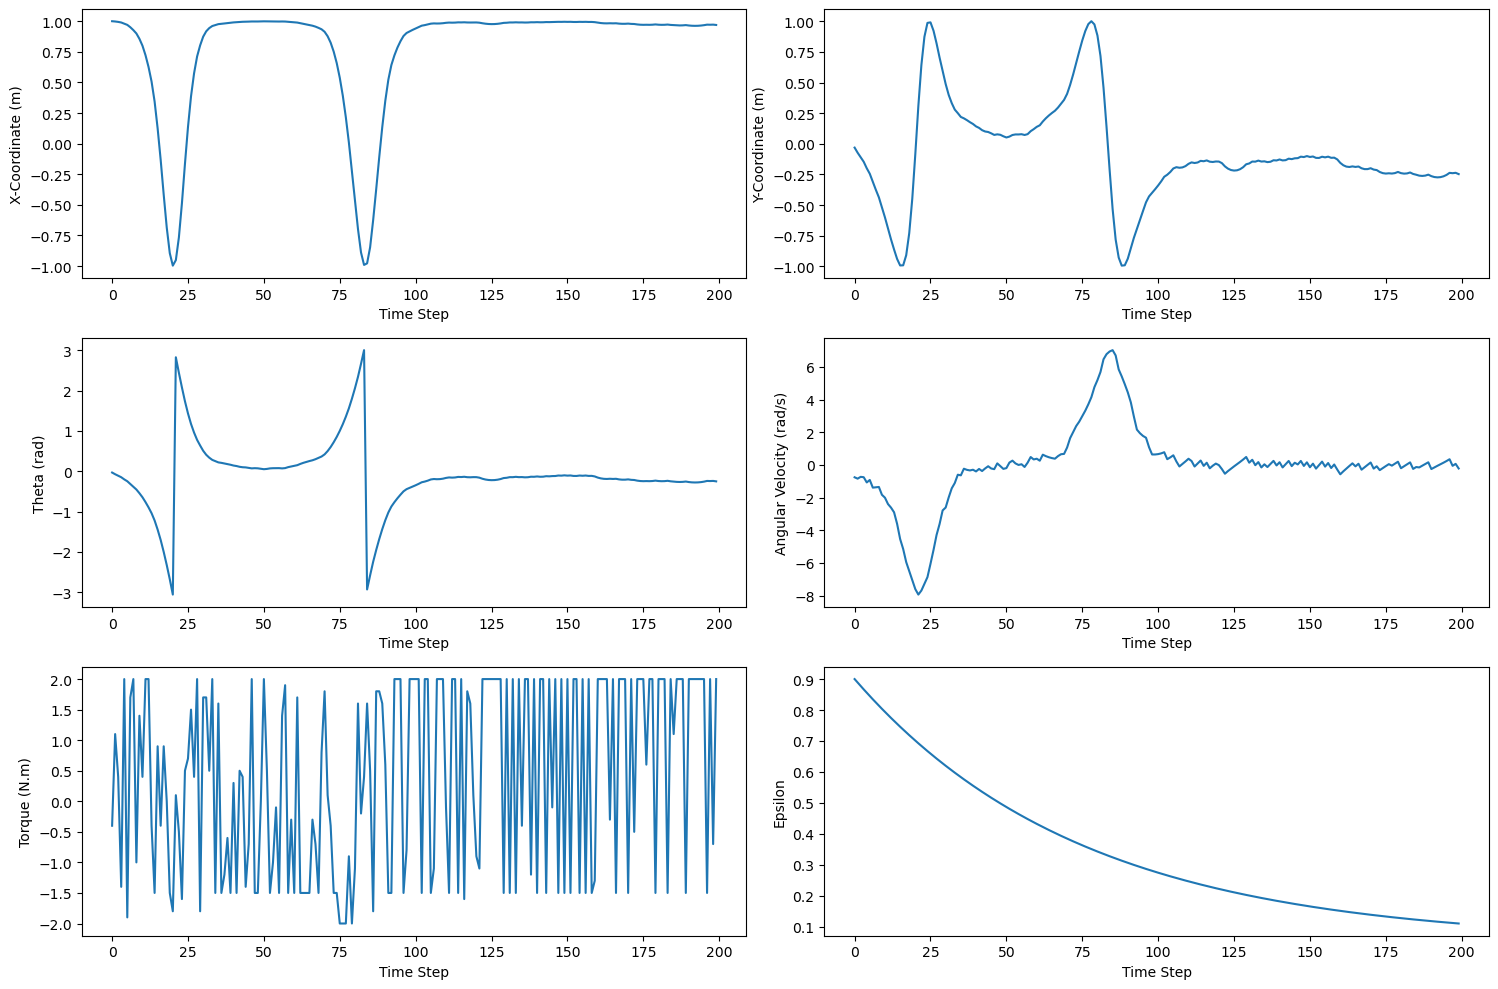

In [23]:
t = np.argmax(average_reward_per_episode)

plt.figure(figsize=(15, 10))
plt.subplot(3,2,1)
plt.plot(x_coordinate_per_time_step[t, :])
plt.xlabel('Time Step')
plt.ylabel('X-Coordinate (m)')

plt.subplot(3,2,2)
plt.plot(y_coordinate_per_time_step[t, :])
plt.xlabel('Time Step')
plt.ylabel('Y-Coordinate (m)')

plt.subplot(3,2,3)
plt.plot(np.arctan2(y_coordinate_per_time_step[t, :], x_coordinate_per_time_step[t, :]))
plt.xlabel('Time Step')
plt.ylabel('Theta (rad)')

plt.subplot(3,2,4)
plt.plot(angular_velocity_per_time_step[t, :])
plt.xlabel('Time Step')
plt.ylabel('Angular Velocity (rad/s)')

plt.subplot(3,2,5)
plt.plot(action_per_time_step[t, :])
plt.xlabel('Time Step')
plt.ylabel('Torque (N.m)')

plt.subplot(3,2,6)
plt.plot([EPS_END + (EPS_START - EPS_END) * math.exp(-1. * s_d / EPS_DECAY) for s_d in range(num_time_steps)]);
plt.xlabel('Time Step')
plt.ylabel('Epsilon');

plt.tight_layout()

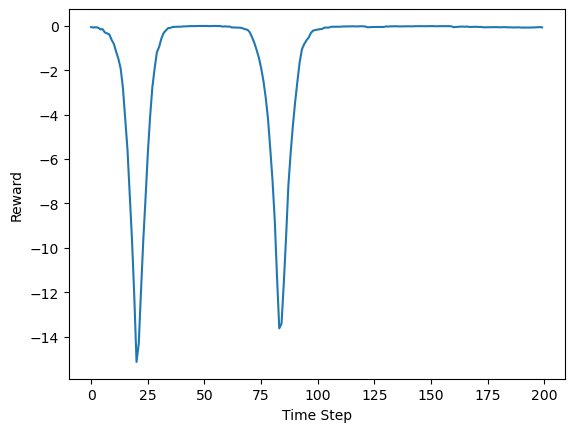

In [24]:
plt.plot(reward_per_time_step[t, :])
plt.xlabel('Time Step')
plt.ylabel('Reward');

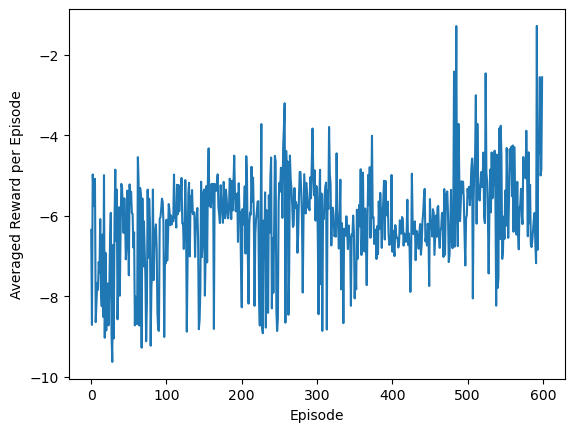

In [25]:
plt.plot(average_reward_per_episode)
plt.xlabel('Episode')
plt.ylabel('Averaged Reward per Episode');

592